In [70]:
# HOXB13 expression for project with Dennis Sgroi
# 12/15/2023
# Esther Rheinbay


In [183]:
import sys
import pandas as pd
import numpy as np

from scipy.stats import ttest_ind, spearmanr, wilcoxon, mannwhitneyu
from statsmodels.stats.multitest import fdrcorrection
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.rcParams['pdf.fonttype'] = 42

workdir = '/Users/esther/Documents/Projects/2019/Sgroi_HOXB13/'

In [72]:
# General sample info from https://gdc.cancer.gov/about-data/publications/pancanatlas
TCGA_sample_info = pd.read_excel('/Users/esther/Documents/Reference_data/TCGA/PANCAN_ATLAS/TCGA-CDR-SupplementalTableS1.xlsx', sheet_name=0,  header=0, index_col=1)
TCGA_survival = pd.read_excel('/Users/esther/Documents/Reference_data/TCGA/PANCAN_ATLAS/TCGA-CDR-SupplementalTableS1.xlsx', sheet_name="ExtraEndpoints", index_col=1)


In [73]:
# TCGA pancan expression data
# gene expression from pancan atlas (https://gdc.cancer.gov/about-data/publications/pancanatlas)
TCGA_pancan_exp = pd.read_csv('/Users/esther/Documents/Reference_data/TCGA/PANCAN_ATLAS/EBPlusPlusAdjustPANCAN_IlluminaHiSeq_RNASeqV2.geneExp.tsv', sep='\t', header=0, index_col=0)

# sample codes from code table https://gdc.cancer.gov/resources-tcga-users/tcga-code-tables/sample-type-codes
tumor_codes = ['01', '02', '03', '04', '04', '06', '07', '08', '09']
normal_codes = ['10', '11', '12', '13', '14']


# divide samples into tumors and normals (-01*- are tumor samples; -06A- is a metastatic sample); most normals have code -11A-
stype = ['tumor' if x.split('-')[3][0:2] in tumor_codes else 'normal' if x.split('-')[3][0:2] in normal_codes else 'NA' for x in TCGA_pancan_exp.columns.values]

#stype = ['tumor' if ('-01A-' in x or '-01B-' in x or '-01C-' in x or '-06A-' in x) else 'normal' for x in TCGA_pancan_exp.columns.values]
sample_type = pd.Series(stype, index = TCGA_pancan_exp.columns.values)

#change index to gene names only
TCGA_pancan_exp.index = map(lambda x: x.split('|')[0], TCGA_pancan_exp.index.values)

# extract tumors only
tumor_exp = TCGA_pancan_exp[sample_type[sample_type=='tumor'].index.values]

# extract normal samples only
normal_exp = TCGA_pancan_exp[sample_type[sample_type=='normal'].index.values]

# shorten column names/patient IDs
tumor_exp.rename(columns = lambda x: x[0:12], inplace=True)
normal_exp.rename(columns = lambda x: x[0:12], inplace=True)

# remove duplicate gene expression data for the same sample
tumor_exp_unique = tumor_exp.iloc[:, ~tumor_exp.columns.duplicated()]
normal_exp_unique = normal_exp.iloc[:, ~normal_exp.columns.duplicated()]


/var/folders/bb/yb3gg4014bv4v88wmr3c_95c0000gq/T/ipykernel_21223/2632293095.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tumor_exp.rename(columns = lambda x: x[0:12], inplace=True)
/var/folders/bb/yb3gg4014bv4v88wmr3c_95c0000gq/T/ipykernel_21223/2632293095.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  normal_exp.rename(columns = lambda x: x[0:12], inplace=True)


In [74]:
# BRCA expression only
BRCA_exp = tumor_exp_unique[[x for x in TCGA_sample_info.index if TCGA_sample_info.loc[x].type=='BRCA' and x in tumor_exp_unique.columns]]
BRCA_exp

,TCGA-3C-AAAU,TCGA-3C-AALI,TCGA-3C-AALJ,TCGA-3C-AALK,TCGA-4H-AAAK,TCGA-5L-AAT0,TCGA-5L-AAT1,TCGA-5T-A9QA,TCGA-A1-A0SB,TCGA-A1-A0SD,...,TCGA-UL-AAZ6,TCGA-UU-A93S,TCGA-V7-A7HQ,TCGA-W8-A86G,TCGA-WT-AB41,TCGA-WT-AB44,TCGA-XX-A899,TCGA-XX-A89A,TCGA-Z7-A8R5,TCGA-Z7-A8R6
?,0.0000,0.0000,0.9066,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
?,16.3644,9.2659,11.6228,12.0894,6.8468,3.9889,0.0000,1.4644,15.3396,9.5178,...,0.3992,4.3126,0.0000,5.5624,0.0000,0.0000,14.3858,22.3240,2.2638,6.8865
?,12.9316,17.3790,9.2294,11.0799,14.4298,13.6090,10.5949,8.9958,14.3935,11.3241,...,14.3720,10.8828,3.0792,14.3711,6.3091,3.2580,21.4409,27.2744,7.2933,24.7795
?,52.1503,69.7553,154.2970,143.8640,84.2128,114.2570,115.9980,107.5630,116.3870,60.2630,...,135.6240,136.1290,29.9974,128.3150,53.6278,42.2643,137.7760,64.1427,85.0461,167.5510
?,408.0760,563.8930,1360.8300,865.5360,766.3830,807.7430,1108.3900,1420.5000,657.2810,977.9180,...,1570.1400,2886.4000,1721.8800,697.6740,1245.2700,1877.4200,652.7560,722.7210,1140.2800,1003.5700
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZYG11A,258.4940,198.4770,331.8220,175.4240,14.0426,15.8381,53.7897,2.0921,19.3716,33.0825,...,73.8563,11.5774,40.0294,112.4820,46.5300,98.5543,21.2598,164.3840,51.9667,139.5390
ZYG11B,1208.3700,603.5890,532.1850,607.3650,775.7450,626.4850,513.4470,321.6530,1364.5700,868.0840,...,484.6570,559.3340,380.5880,533.9340,231.8610,315.2110,688.1890,746.8120,505.9280,573.4670
ZYX,3507.2500,5504.6200,5458.7500,5691.3500,4041.7000,4131.9800,4418.0900,3221.7600,6186.7300,3559.6700,...,4163.5000,5594.0700,6453.3600,5550.5500,6675.8700,10937.1000,5118.1100,5477.5600,6675.6300,3402.5200
ZZEF1,1894.9300,1318.6500,942.8830,781.1340,831.9150,922.1290,1411.5700,1115.0600,1931.3000,1278.9700,...,1242.3800,538.3500,747.6270,970.1000,558.3600,800.6520,1933.8600,1437.4100,754.4130,564.4190


In [75]:
# tumor ID lists from Irene
TCGA_HER2_only = pd.read_csv('/Users/esther/Documents/Projects/2019/Sgroi_HOXB13/Manuscript/Irene_sample_lists/ERBB2only_patient_list.txt', sep='\t', squeeze=True).to_list()
TCGA_HER2_HOXB13_cogain = pd.read_csv('/Users/esther/Documents/Projects/2019/Sgroi_HOXB13/Manuscript/Irene_sample_lists/cogain_patient_list.txt', sep='\t', squeeze=True).to_list()
TCGA_HER2_HOXB13_gap = pd.read_csv('/Users/esther/Documents/Projects/2019/Sgroi_HOXB13/Manuscript/Irene_sample_lists/Gap_patient_list.txt', sep='\t', squeeze=True).to_list()

/var/folders/bb/yb3gg4014bv4v88wmr3c_95c0000gq/T/ipykernel_21223/2271866891.py:2: FutureWarning: The squeeze argument has been deprecated and will be removed in a future version. Append .squeeze("columns") to the call to squeeze.


  TCGA_HER2_only = pd.read_csv('/Users/esther/Documents/Projects/2019/Sgroi_HOXB13/Manuscript/Irene_sample_lists/ERBB2only_patient_list.txt', sep='\t', squeeze=True).to_list()
/var/folders/bb/yb3gg4014bv4v88wmr3c_95c0000gq/T/ipykernel_21223/2271866891.py:3: FutureWarning: The squeeze argument has been deprecated and will be removed in a future version. Append .squeeze("columns") to the call to squeeze.


  TCGA_HER2_HOXB13_cogain = pd.read_csv('/Users/esther/Documents/Projects/2019/Sgroi_HOXB13/Manuscript/Irene_sample_lists/cogain_patient_list.txt', sep='\t', squeeze=True).to_list()
/var/folders/bb/yb3gg4014bv4v88wmr3c_95c0000gq/T/ipykernel_21223/2271866891.py:4: FutureWarning: The squeeze argument has been deprecated and will be removed in a future version.

In [76]:
# list of gap genes
gap_genes = list(set(pd.read_csv('/Users/esther/Documents/Projects/2019/Sgroi_HOXB13/Gap_genes_from_UCSC_chr17-40382339-44720147.txt', sep='\t', header=0)['name2'].to_list()))
gap_genes

['LOC105371795',
 'RAMP2',
 'AOC3',
 'PLCD3',
 'KANSL1-AS1',
 'HDAC5',
 'GJC1',
 'GPATCH8',
 'LINC00671',
 'BECN1',
 'DBF4B',
 'TMUB2',
 'ACBD4',
 'GRN',
 'FMNL1-DT',
 'SPATA32',
 'STH',
 'MIR548AT',
 'MIR6782',
 'TUBG1',
 'CCDC43',
 'ARL17A',
 'BRCA1',
 'VAT1',
 'CD300LG',
 'CRHR1',
 'CCR10',
 'G6PC1',
 'ADAM11',
 'FAM171A2',
 'SOST',
 'LINC02210-CRHR1',
 'LRRC37A2',
 'IFI35',
 'MIR6781',
 'HIGD1B',
 'RUNDC3A',
 'LINC02210',
 'HSD17B1',
 'VPS25',
 'LINC01180',
 'WNK4',
 'NAGS',
 'TMEM101',
 'HEXIM2',
 'RND2',
 'RUNDC1',
 'ETV4',
 'RPL27',
 'EZH1',
 'AARSD1',
 'FAM215A',
 'ASB16',
 'HSD17B1-AS1',
 'ATP6V0A1',
 'HROB',
 'NBR1',
 'CFAP97D1',
 'TUBG2',
 'LOC101929767',
 'MEIOC',
 'SLC25A39',
 'MIR2117HG',
 'MPP2',
 'AOC2',
 'FAM187A',
 'STAT5B',
 'KIF18B',
 'MIR2117',
 'PLEKHH3',
 'MIR4315-1',
 'RAMP2-AS1',
 'CAVIN1',
 'MAPT-IT1',
 'LSM12',
 'CNTNAP1',
 'ARL4D',
 'NMT1',
 'LINC01976',
 'NSF',
 'PTGES3L-AARSD1',
 'FZD2',
 'MIR6780A',
 'NAGLU',
 'MIR6783',
 'DCAKD',
 'LRRC37A',
 'MAP3K14-AS

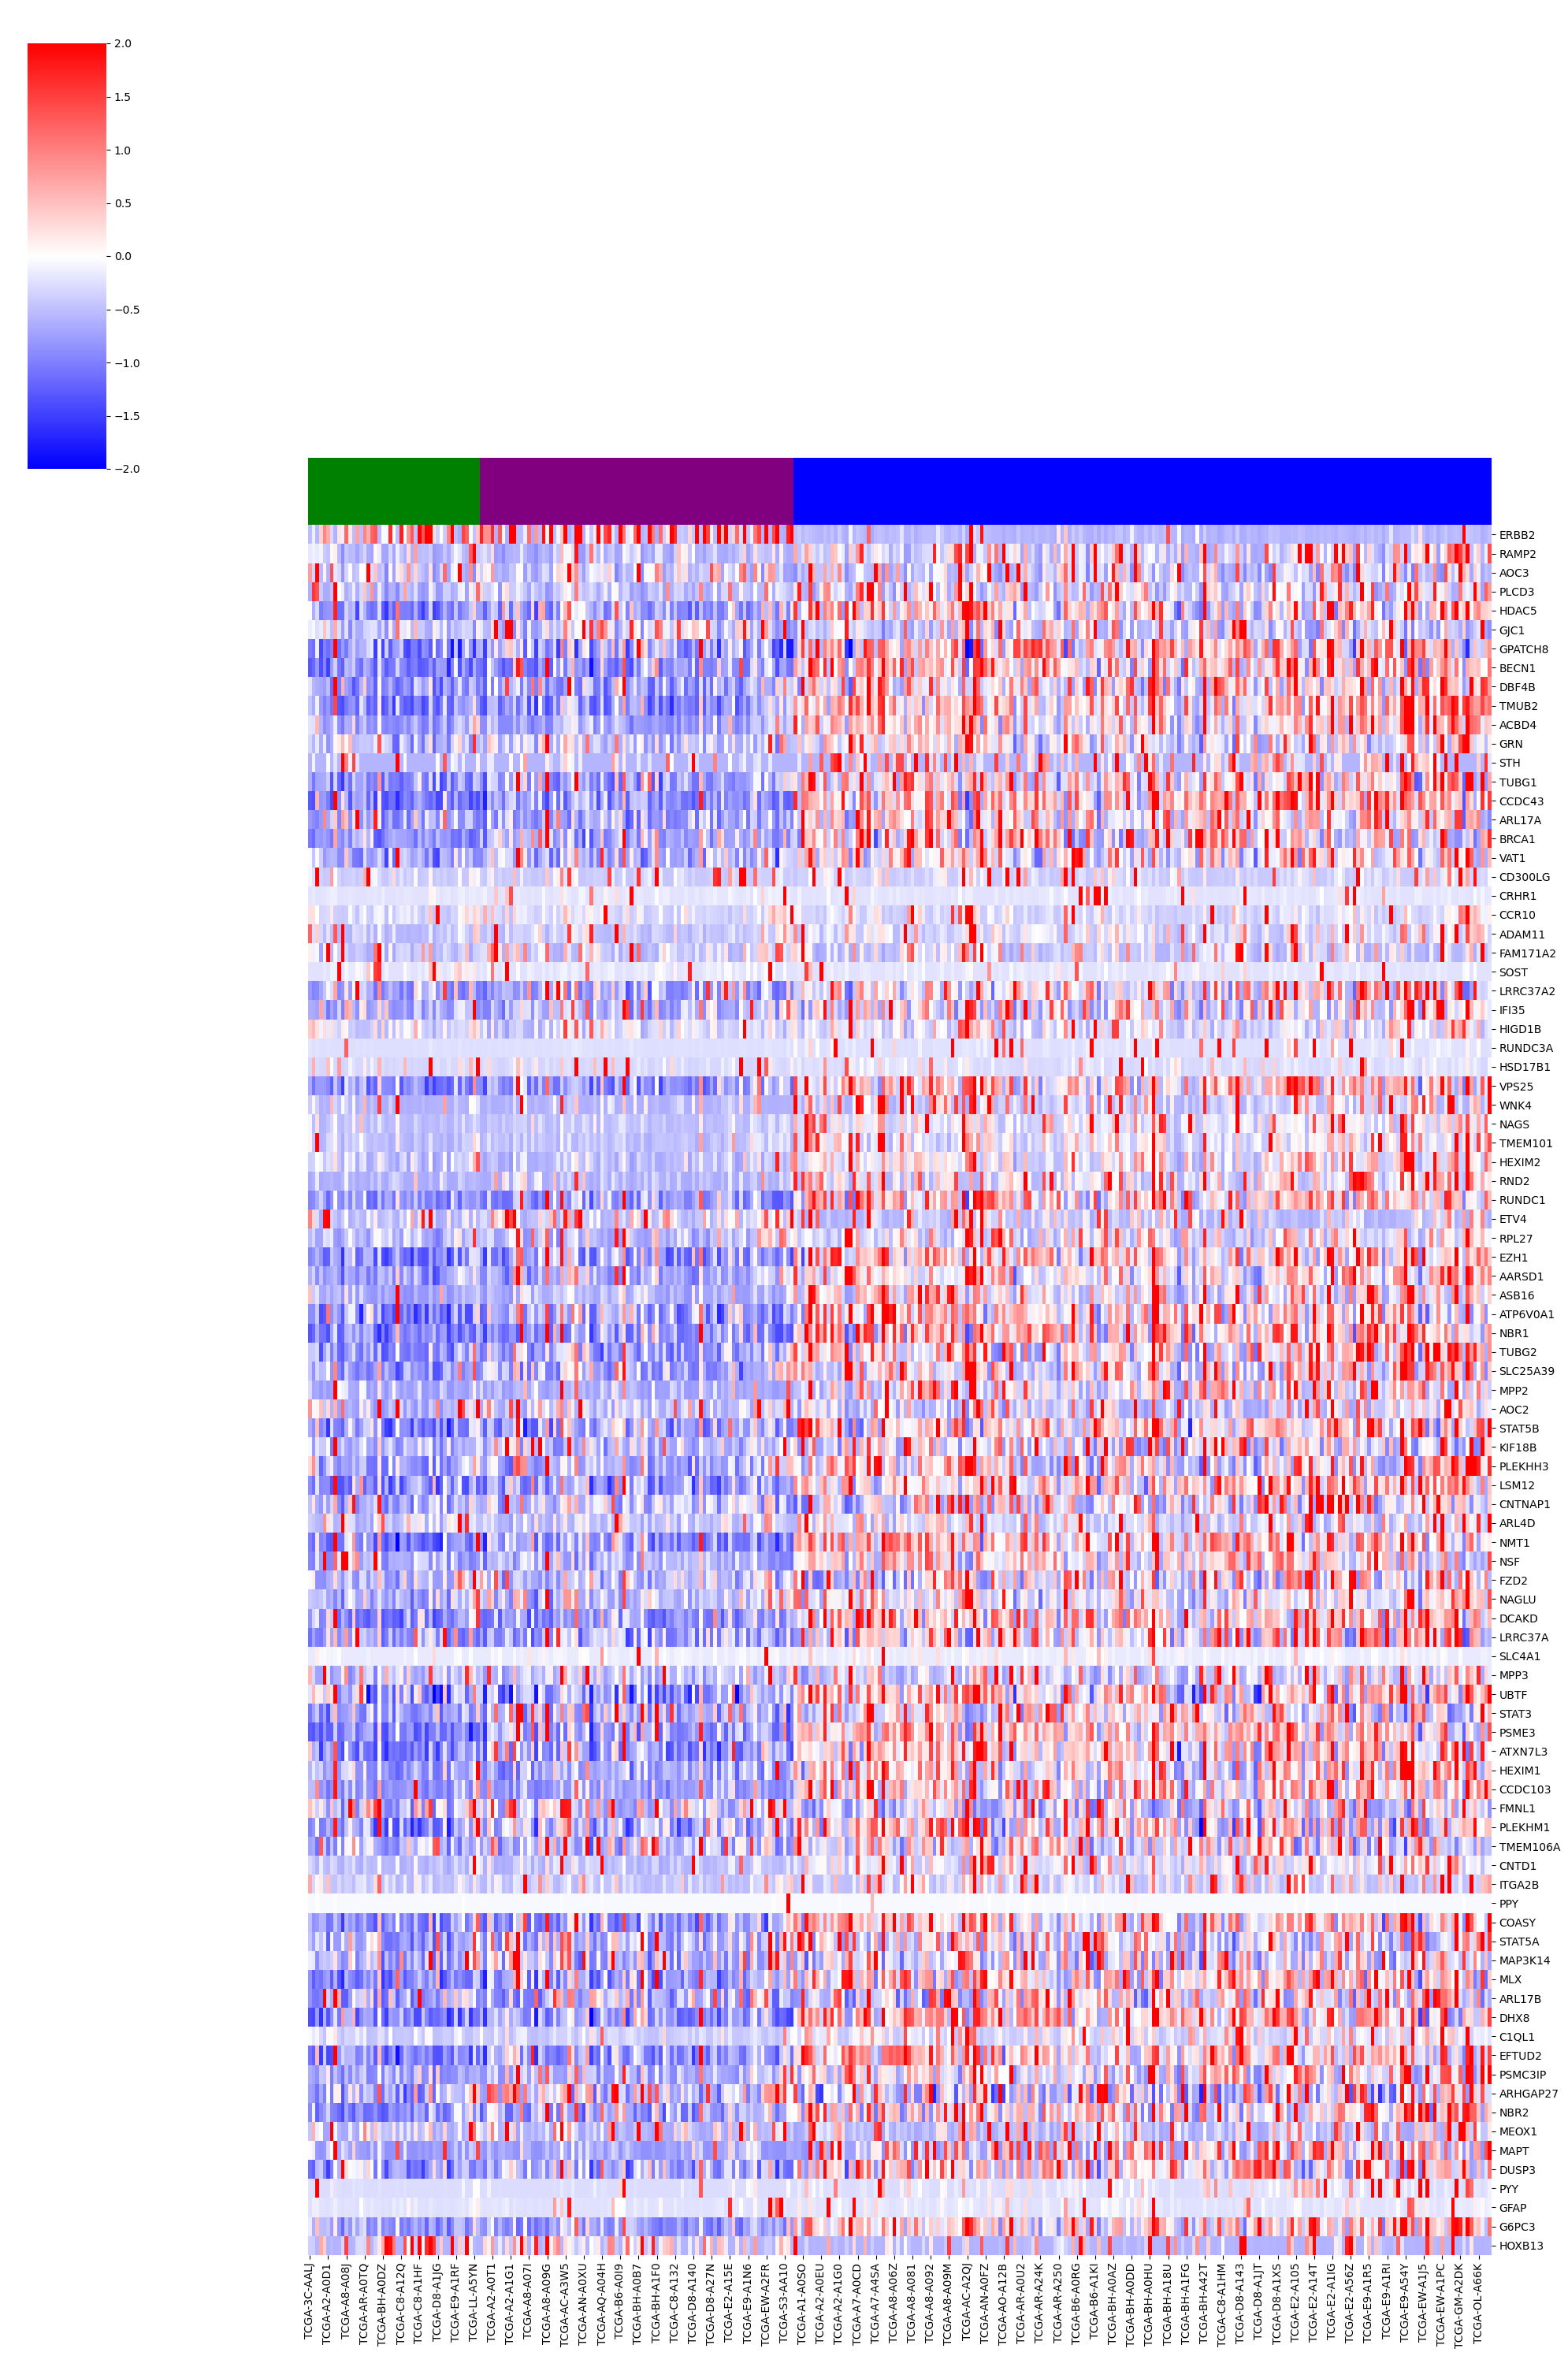

In [86]:
# heatmap of gap genes in different sets
# Figure 3G

All_HER2 =  TCGA_HER2_HOXB13_gap + TCGA_HER2_only + TCGA_HER2_HOXB13_cogain

col_colors =  ['green']*len(TCGA_HER2_HOXB13_gap) +  ['purple']*len(TCGA_HER2_only) + ['blue'] * len(TCGA_HER2_HOXB13_cogain)
genes_to_plot = ['ERBB2'] + [x for x in gap_genes if x in BRCA_exp.index] + ['HOXB13']

df = BRCA_exp.loc[genes_to_plot][[x for x in All_HER2 if x in BRCA_exp.columns]]
df
sns.clustermap(df.dropna(), cmap = 'bwr', col_cluster=False, row_cluster=False, z_score=2, vmax=2, vmin = -2, center=0, col_colors=col_colors, figsize = (20,30))
#sns.clustermap(df.dropna(), cmap = 'bwr', col_cluster=False, row_cluster=False, z_score=2, vmax=2, vmin = -2, center=0, col_colors=col_colors, figsize = (20,10))

# Figure 3F
plt.savefig('/Users/esther/Documents/Projects/2019/Sgroi_HOXB13/Manuscript/Figures/3G_gene_expression_for_tumor_lists_heatmap.pdf')

In [78]:
# ER status
subtypes = pd.read_csv('/Users/esther/Documents/Reference_data/TCGA/BRCA/TCGA_2015_suppTable2.tsv', sep='\t', header=0, index_col = 0, na_values='#N/A', comment='*')

TNBC = subtypes[(subtypes['ER IHC']=='Negative') & (subtypes['HER2 IHC'] =='Negative') & (subtypes['PR IHC'] =='Negative')].index.to_list()


/Users/esther/anaconda3/lib/python3.10/site-packages/seaborn/categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:grey'` for same effect.
  warnings.warn(msg, FutureWarning)
/Users/esther/anaconda3/lib/python3.10/site-packages/seaborn/categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:grey'` for same effect.
  warnings.warn(msg, FutureWarning)


cogain      198
HER2only     91
TNBC         70
gap          47
Name: HER2_class, dtype: int64

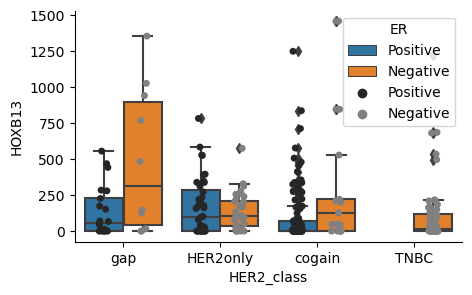

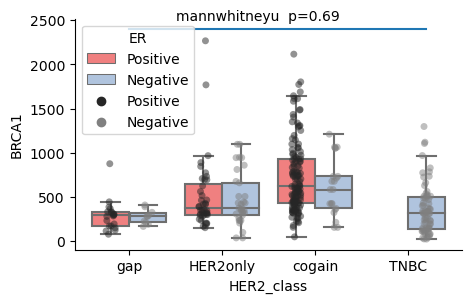

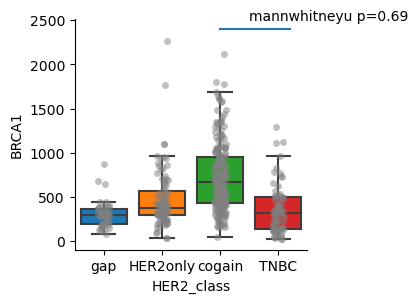

In [113]:
df2 = BRCA_exp.loc['HOXB13'][All_HER2+TNBC].to_frame()
df2['BRCA1'] = BRCA_exp.loc['BRCA1'][All_HER2+TNBC]
df2['HER2_class'] = df2.apply(lambda x: "gap" if x.name in TCGA_HER2_HOXB13_gap else ('cogain' if x.name in TCGA_HER2_HOXB13_cogain else ('HER2only' if x.name in TCGA_HER2_only else ('TNBC' if x.name in TNBC else 'other'))), axis=1)
df2['ER'] = df2.apply(lambda x: subtypes.loc[x.name]['ER IHC'] if x.name in subtypes.index else 'NA', axis=1)



fig, ax = plt.subplots(1,1, figsize = (5,3))
sns.boxplot(x = 'HER2_class', y = 'HOXB13', hue = 'ER' ,data = df2, hue_order = ['Positive', 'Negative'])
sns.stripplot(x = 'HER2_class', y = 'HOXB13', hue = 'ER' ,data = df2, dodge=True, color = 'grey', hue_order = ['Positive', 'Negative'])
sns.despine()



fig, ax = plt.subplots(1,1, figsize = (5,3))
sns.boxplot(x = 'HER2_class', y = 'BRCA1', hue = 'ER' ,data = df2, hue_order = ['Positive', 'Negative'], fliersize=0, palette = ['lightcoral', 'lightsteelblue'], saturation = 1)
sns.stripplot(x = 'HER2_class', y = 'BRCA1', hue = 'ER' ,data = df2, dodge=True, color = 'grey', hue_order = ['Positive', 'Negative'], alpha=0.5)
sns.despine()

ax.text(0.5, 2500, 'mannwhitneyu  p=' + str(round(mannwhitneyu(df2[df2.HER2_class=='gap'].BRCA1.dropna(), df2[df2.HER2_class=='TNBC'].BRCA1.dropna()).pvalue,2)))
ax.plot((0, 3.2), (2400, 2400))
mannwhitneyu(df2[df2.HER2_class=='HER2only'].BRCA1.dropna(), df2[df2.HER2_class=='TNBC'].BRCA1.dropna()).pvalue
mannwhitneyu(df2[df2.HER2_class=='cogain'].BRCA1.dropna(), df2[df2.HER2_class=='TNBC'].BRCA1.dropna())

fig, ax = plt.subplots(1,1, figsize = (3,3))
sns.boxplot(x = 'HER2_class', y = 'BRCA1', data = df2,  fliersize=0, saturation = 1, order = [ 'gap', 'HER2only', 'cogain', 'TNBC'])
sns.stripplot(x = 'HER2_class', y = 'BRCA1' ,data = df2, dodge=True, color = 'grey', order = [ 'gap', 'HER2only', 'cogain', 'TNBC'], alpha=0.5)
sns.despine()

ax.text(2.5, 2500, 'mannwhitneyu p=' + str(round(mannwhitneyu(df2[df2.HER2_class=='gap'].BRCA1.dropna(), df2[df2.HER2_class=='TNBC'].BRCA1.dropna()).pvalue,2)))
ax.plot((2, 3.2), (2400, 2400))
mannwhitneyu(df2[df2.HER2_class=='HER2only'].BRCA1.dropna(), df2[df2.HER2_class=='TNBC'].BRCA1.dropna()).pvalue
mannwhitneyu(df2[df2.HER2_class=='cogain'].BRCA1.dropna(), df2[df2.HER2_class=='TNBC'].BRCA1.dropna())


plt.savefig('/Users/esther/Documents/Projects/2019/Sgroi_HOXB13/Manuscript/Figures/3H_BRCA1_expression_by_group.pdf')

df2.HER2_class.value_counts()

In [80]:
len(TCGA_HER2_only )

86

In [81]:
# age distribution

TCGA_sample_info['HER2_class'] = TCGA_sample_info.apply(lambda x: 'HER2_only' if x.name in TCGA_HER2_only else ('cogain' if x.name in TCGA_HER2_HOXB13_cogain else ('gap' if x.name in TCGA_HER2_HOXB13_gap else 'None')), axis=1)

<Axes: xlabel='HER2_class', ylabel='age_at_initial_pathologic_diagnosis'>

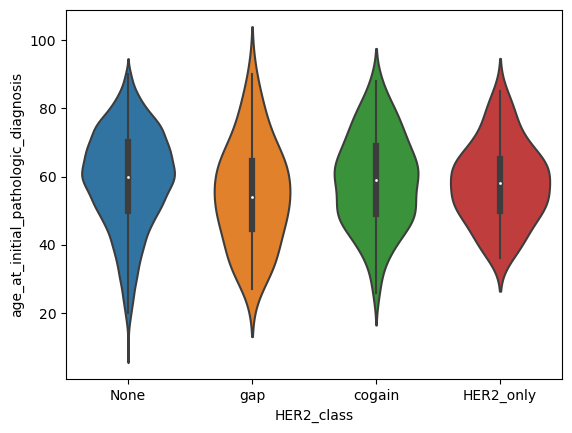

In [82]:

sns.violinplot(x = 'HER2_class' , y = 'age_at_initial_pathologic_diagnosis', data = TCGA_sample_info)

In [83]:
# write expression and cls file for GSEA
#BRCA_exp.to_csv('/Users/esther/Documents/Projects/2019/Sgroi_HOXB13/GSEA/TCGA_BRCA_exp.txt', sep='\t')


TCGA_sample_info['HER2_class'].loc[[x for x in BRCA_exp.columns if x in TCGA_sample_info.index]].T.to_csv('/Users/esther/Documents/Projects/2019/Sgroi_HOXB13/GSEA/t', sep='\t')
TCGA_sample_info['HER2_class'].loc[[x for x in BRCA_exp.columns if x in TCGA_sample_info.index]]
TCGA_sample_info[TCGA_sample_info.type=='BRCA'].shape

(1097, 34)

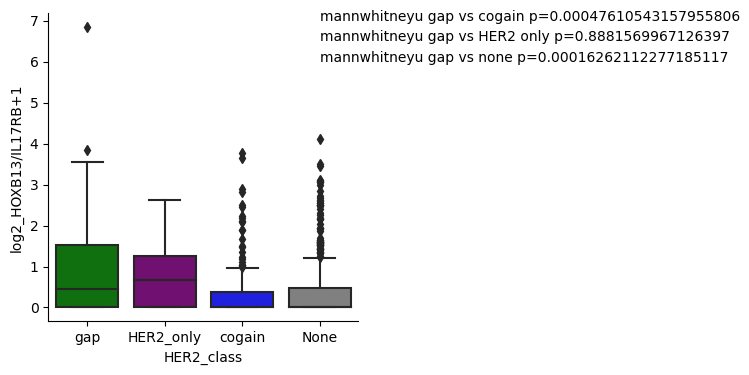

In [195]:
# Figure 6C HOXB13/IL17RB
"""
subtypes['HOXB13/IL17RB'] = subtypes.apply(lambda x: BRCA_exp.loc['HOXB13'][x.name]/BRCA_exp.loc['IL17RB'][x.name], axis=1)
subtypes['log2_HOXB13/IL17RB+1'] = subtypes.apply(lambda x: np.log2(x['HOXB13/IL17RB']+1), axis=1)
subtypes['HOXB13'] = subtypes.apply(lambda x: BRCA_exp.loc['HOXB13'][x.name], axis=1)
subtypes['HER2_class'] = subtypes.apply(lambda x: TCGA_sample_info.loc[x.name]['HER2_class'], axis=1)

fig, ax = plt.subplots(2,1, figsize = (4,4), sharex=True)
sns.boxplot(x = 'HER2_class', y = 'HOXB13/IL17RB',  data = subtypes,  order = ['gap', 'HER2_only', 'cogain', 'None'], palette = ['green', 'purple', 'blue', 'grey'], ax = ax[0])
ax[0].set_ylim(bottom = 105)
ax[0].xaxis.set_visible(False)

sns.boxplot(x = 'HER2_class', y = 'HOXB13/IL17RB',  data = subtypes,  order = ['gap', 'HER2_only', 'cogain', 'None'], palette = ['green', 'purple', 'blue', 'grey'], ax = ax[1])
ax[1].set_ylim(0,20)
sns.despine()
ax[1].text(3, 15, 'mannwhitneyu gap vs cogain p=' + str((mannwhitneyu(subtypes[(subtypes['HER2_class']=='gap')]['HOXB13/IL17RB'], subtypes[(subtypes['HER2_class']=='cogain')]['HOXB13/IL17RB']).pvalue)))
ax[1].text(3, 13, 'mannwhitneyu gap vs HER2 only p=' + str((mannwhitneyu(subtypes[(subtypes['HER2_class']=='gap')]['HOXB13/IL17RB'], subtypes[(subtypes['HER2_class']=='HER2_only')]['HOXB13/IL17RB']).pvalue)))
ax[1].text(3, 11, 'mannwhitneyu gap vs none p=' + str((mannwhitneyu(subtypes[(subtypes['HER2_class']=='gap')]['HOXB13/IL17RB'], subtypes[(subtypes['HER2_class']=='None')]['HOXB13/IL17RB']).pvalue)))

subtypes['HER2_class'].value_counts()
plt.savefig('/Users/esther/Documents/Projects/2019/Sgroi_HOXB13/Manuscript/Figures/6C_HOXB13_IL17RB_by_group.pdf')
"""
fig, ax = plt.subplots(1,1, figsize = (4,4), sharex=True)
sns.boxplot(x = 'HER2_class', y = 'log2_HOXB13/IL17RB+1',  data = subtypes,  order = ['gap', 'HER2_only', 'cogain', 'None'], palette = ['green', 'purple', 'blue', 'grey'])
#ax[0].set_ylim(bottom = 105)
#x[0].xaxis.set_visible(False)

#sns.boxplot(x = 'HER2_class', y = 'log2_HOXB13/IL17RB+1',  data = subtypes,  order = ['gap', 'HER2_only', 'cogain', 'None'], palette = ['green', 'purple', 'blue', 'grey'], ax = ax[1])
#ax[1].set_ylim(0,20)
sns.despine()
ax.text(3, 7, 'mannwhitneyu gap vs cogain p=' + str((mannwhitneyu(subtypes[(subtypes['HER2_class']=='gap')]['log2_HOXB13/IL17RB+1'], subtypes[(subtypes['HER2_class']=='cogain')]['log2_HOXB13/IL17RB+1']).pvalue)))
ax.text(3, 6.5, 'mannwhitneyu gap vs HER2 only p=' + str((mannwhitneyu(subtypes[(subtypes['HER2_class']=='gap')]['log2_HOXB13/IL17RB+1'], subtypes[(subtypes['HER2_class']=='HER2_only')]['log2_HOXB13/IL17RB+1']).pvalue)))
ax.text(3, 6, 'mannwhitneyu gap vs none p=' + str((mannwhitneyu(subtypes[(subtypes['HER2_class']=='gap')]['log2_HOXB13/IL17RB+1'], subtypes[(subtypes['HER2_class']=='None')]['log2_HOXB13/IL17RB+1']).pvalue)))

subtypes['HER2_class'].value_counts()
plt.savefig('/Users/esther/Documents/Projects/2019/Sgroi_HOXB13/Manuscript/Figures/6C_HOXB13_IL17RB_by_group_log2.pdf')


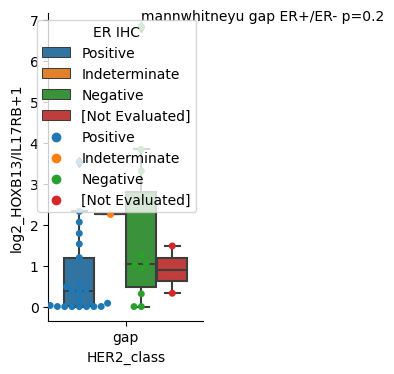

In [206]:
# HOXB13/IL717RB by ER status

fig, ax = plt.subplots(1,1, figsize = (2,4))
sns.boxplot(x = 'HER2_class', y = 'log2_HOXB13/IL17RB+1', hue = 'ER IHC', data = subtypes[subtypes.HER2_class=='gap'], order = ['gap'])
sns.despine()
sns.swarmplot(x = 'HER2_class', y = 'log2_HOXB13/IL17RB+1', hue = 'ER IHC', data = subtypes[subtypes.HER2_class=='gap'], dodge=True)

ax.text(0.1, 7, 'mannwhitneyu gap ER+/ER- p=' + str(round(mannwhitneyu(subtypes[(subtypes['HER2_class']=='gap') & (subtypes['ER IHC']=='Positive')]['log2_HOXB13/IL17RB+1'], subtypes[(subtypes['HER2_class']=='gap') & (subtypes['ER IHC']=='Negative')]['log2_HOXB13/IL17RB+1']).pvalue,2)))
plt.savefig('/Users/esther/Documents/Projects/2019/Sgroi_HOXB13/Manuscript/Figures/6D_HOXB13_IL17RB_ER_status_log2.pdf')
